In [350]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import seaborn as sns
from pysindy import SINDy
from pysindy.feature_library import PolynomialLibrary
from pysindy.optimizers import STLSQ


In [334]:
def load_image_sequence(folder_path, filenames, size=(64, 64), grayscale=True):
    data = []
    for fname in sorted(filenames):
        path = os.path.join(folder_path, fname)
        img = Image.open(path)
        if grayscale:
            img = img.convert('L')  # convert to grayscale
        img = img.resize(size)
        img_arr = np.array(img) / 255.0  # normalize to [0, 1]
        data.append(img_arr)
    return np.stack(data)  # shape: (time, height, width)

In [335]:
# Red dye images
red_folder = "red-dye"
red_filenames = [f"dye{i}.png" for i in range(1, 19)]  # dye1.png to dye18.png
red_data = load_image_sequence(red_folder, red_filenames)

# Green dye images
green_folder = "green-dye"
green_filenames = [f"IMG_{i}.JPG" for i in range(6211, 6250)]  # IMG_6211.JPG to IMG_6249.JPG
green_data = load_image_sequence(green_folder, green_filenames)

In [336]:
print(red_data.shape)
print(green_data.shape)

(18, 64, 64)
(39, 64, 64)


In [337]:
# 1. Choose which dataset to work with
u = red_data
dt = 0.4  # assumed time step in seconds

In [338]:
# 2. Define function to compute derivatives
def compute_derivatives(u, dt=10):
    # Apply light smoothing
    u_smoothed = gaussian_filter(u, sigma=(0, 1, 1))  # only spatial smoothing

    # Compute spatial and temporal derivatives
    du_dt = np.gradient(u_smoothed, dt, axis=0)       # time derivative
    ux = np.gradient(u_smoothed, axis=2)              # x-derivative
    uy = np.gradient(u_smoothed, axis=1)              # y-derivative
    uxx = np.gradient(ux, axis=2)                     # second x-derivative
    uyy = np.gradient(uy, axis=1)                     # second y-derivative

    return du_dt, ux, uy, uxx, uyy

In [339]:
# 3. Compute the derivatives
du_dt, ux, uy, uxx, uyy = compute_derivatives(u, dt=dt)

# Build the Laplacian
laplacian = uxx + uyy

# 4. Stack features and flatten
n_t, n_y, n_x = u.shape
X = np.stack([u, laplacian], axis=-1).reshape(-1, 2)
dX = du_dt.reshape(-1, 1)

In [340]:
## 5. Fit SINDy model using a PDE library
feature_library = PolynomialLibrary(degree=1, include_interaction=False)
optimizer = STLSQ(threshold=0.01)

model = SINDy(
     optimizer=optimizer,
    feature_library=feature_library,
    feature_names=['u', 'laplacian']
)

In [341]:
print(f"X shape: {X.shape}")
print(f"DX shape: {dX.shape}")
print(f"NaNs in X: {np.isnan(X).sum()}")
print(f"NaNs in DX: {np.isnan(dX).sum()}")

X shape: (73728, 2)
DX shape: (73728, 1)
NaNs in X: 0
NaNs in DX: 0


In [343]:
# 6. Fit model
model.fit(X, x_dot=dX)
model.print()

(u)' = -0.030 1 + 0.032 u + 0.033 laplacian


In [344]:
print(X.shape)
print(X[:5])

(73728, 2)
[[ 0.65882353 -0.01103753]
 [ 0.70980392 -0.01146305]
 [ 0.70588235 -0.01152181]
 [ 0.70980392 -0.00947358]
 [ 0.70980392 -0.00738493]]


In [345]:
# Use the fitted model to predict derivatives
dX_pred = model.predict(X)
dX_pred

AxesArray([[-0.00952846],
           [-0.00792862],
           [-0.00805468],
           ...,
           [-0.00505343],
           [-0.00476295],
           [-0.00701696]], shape=(73728, 1))

In [346]:
coeffs = model.coefficients()
feature_names = model.get_feature_names()
print(coeffs)
print(feature_names)

[[-0.03002216  0.03165417  0.03268876]]
['1', 'u', 'laplacian']


Laplacian stats: min=-0.0697502894808231, max=0.22323412301177328, mean=-0.0003967470563445666


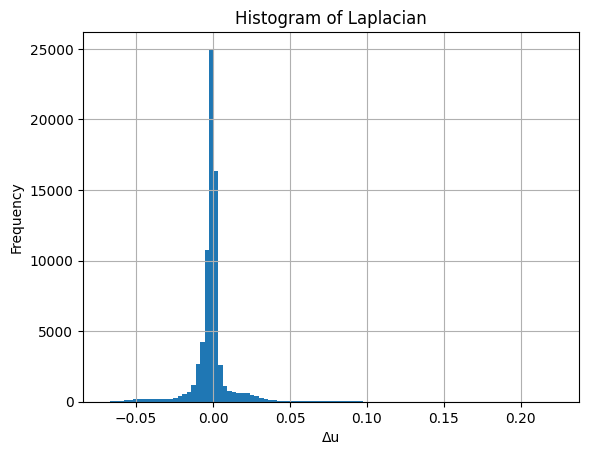

In [347]:
# Plot histogram of laplacian
laplacian = uxx + uyy

print(f"Laplacian stats: min={laplacian.min()}, max={laplacian.max()}, mean={laplacian.mean()}")
plt.hist(laplacian.flatten(), bins=100)
plt.title("Histogram of Laplacian")
plt.xlabel("Δu")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

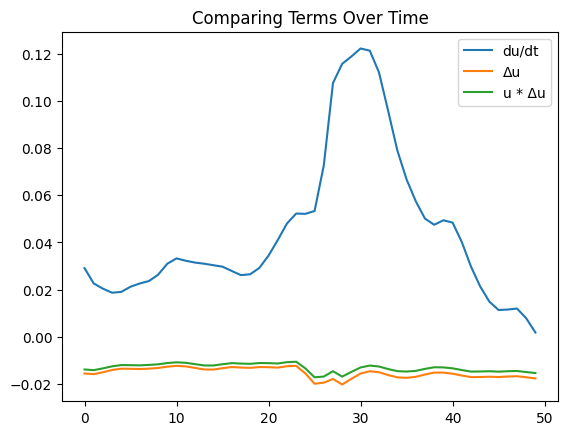

In [348]:
sample_idx = 100  # or any index in the flattened array

plt.plot(du_dt.reshape(-1)[sample_idx:sample_idx+50], label="du/dt")
plt.plot(laplacian.reshape(-1)[sample_idx:sample_idx+50], label="Δu")
plt.plot((u * laplacian).reshape(-1)[sample_idx:sample_idx+50], label="u * Δu")
plt.legend()
plt.title("Comparing Terms Over Time")
plt.show()

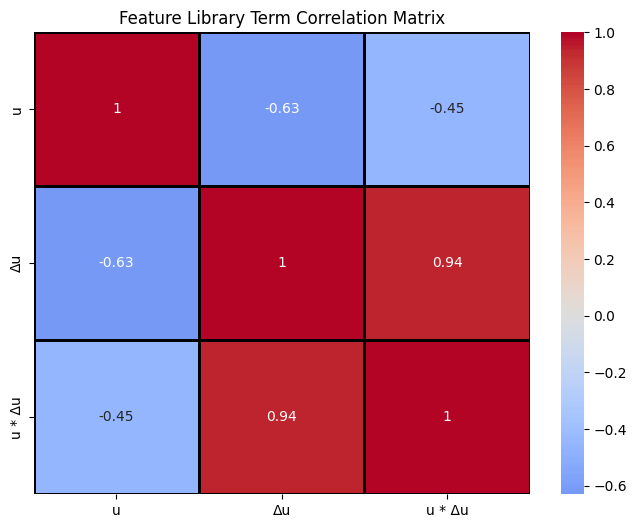

In [351]:
u_lap = u * laplacian  # An example term like u * Δu

# Combine these terms in a 2D array (axis=0 are different terms, axis=1 is spatiotemporal data)
features = np.stack([u.flatten(), laplacian.flatten(), u_lap.flatten()], axis=1)

# Convert to pandas DataFrame for easier manipulation
df_features = pd.DataFrame(features, columns=["u", "Δu", "u * Δu"])

# Compute correlation matrix
corr_matrix = df_features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=1, linecolor="black")
plt.title("Feature Library Term Correlation Matrix")
plt.show()